In [47]:
import json
import time
import warnings
import math

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import Statevector
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.neural_networks import SamplerQNN

algorithm_globals.random_seed = 42

# 5 pieces of data -> 3 pieces of data
#Source: https://qiskit-community.github.io/qiskit-machine-learning/tutorials/12_quantum_autoencoder.html

In [48]:
#Import S&P500 Data
import yfinance as yf
import numpy as np
import pandas as pd
from pandas import DataFrame
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period="max")
del sp500["Dividends"]
del sp500["Stock Splits"]

In [51]:
#Clean data and create intended features
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500["Label"] = 2 * (sp500["Tomorrow"] > sp500["Close"]).astype(int) - 1

#Only uses more recent data
sp500 = sp500.loc["2020-01-01":].copy()

#Includes rolling averages for additional features
horizons = [3,10,25]
new_predictors = []
for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    #Ratio of closing date from yesterday over rolling average of the closing dates
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    #Sum of labels divided by number of days in rolling average
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = (sp500.shift(1).rolling(horizon).sum()["Label"])/horizon
    
    new_predictors += [ratio_column, trend_column]
    
sp500 = sp500.dropna()
sp500

,Open,High,Low,Close,Volume,Tomorrow,Label,Close_Ratio_3,Trend_3,Close_Ratio_10,Trend_10,Close_Ratio_25,Trend_25
Date,,,,,,,,,,,,,
2020-04-21 00:00:00-04:00,2784.810059,2785.540039,2727.100098,2736.560059,5121010000,2799.310059,1,0.973371,-0.333333,0.983522,0.0,1.049963,0.04
2020-04-22 00:00:00-04:00,2787.889893,2815.100098,2775.949951,2799.310059,5084920000,2797.800049,-1,1.004654,-0.333333,1.001041,0.2,1.069605,0.04
2020-04-23 00:00:00-04:00,2810.419922,2844.899902,2794.260010,2797.800049,5773530000,2836.739990,1,1.007167,-0.333333,0.998793,0.0,1.062537,0.04
2020-04-24 00:00:00-04:00,2812.639893,2842.709961,2791.760010,2836.739990,5382810000,2878.479980,1,1.009055,0.333333,1.011001,0.0,1.070376,0.04
2020-04-27 00:00:00-04:00,2854.649902,2887.719971,2852.889893,2878.479980,5203930000,2863.389893,-1,1.014380,0.333333,1.021622,0.2,1.076804,0.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-08 00:00:00-04:00,5211.370117,5219.569824,5197.350098,5202.390137,3278180000,5209.910156,1,1.003422,-0.333333,0.997781,-0.2,1.004405,-0.12
2024-04-09 00:00:00-04:00,5217.029785,5224.810059,5160.779785,5209.910156,3400680000,5160.640137,-1,1.000838,0.333333,0.999382,0.0,1.005244,-0.04
2024-04-10 00:00:00-04:00,5167.879883,5178.430176,5138.700195,5160.640137,3845930000,5199.060059,1,0.994155,-0.333333,0.990747,0.0,0.995107,-0.04


In [52]:
#Makes the data into percentages so it can be encoded into the quantum circuit
sp500["Close"] = (sp500["Close"]-sp500["Open"])/sp500["Open"]
sp500["High"] = (sp500["High"]-sp500["Open"])/sp500["Open"]
sp500["Low"] = (sp500["Low"]-sp500["Open"])/sp500["Open"]
sp500["Volume"] = (sp500["Volume"] - sp500["Volume"].min())/sp500["Volume"].max()

#Drops data that we don't want to use in training
predictors = sp500.drop(["Open", "Tomorrow","Label"], axis=1)
predictors = DataFrame.to_numpy(predictors)
print(predictors)
labels = (DataFrame.to_numpy(sp500))[:,6]
num_features = np.size(predictors, axis=1)

[[ 2.62129357e-04 -2.07231228e-02 -1.73261368e-02 ...  0.00000000e+00
   1.04996297e+00  4.00000000e-02]
 [ 9.76014338e-03 -4.28278801e-03  4.09634758e-03 ...  2.00000000e-01
   1.06960474e+00  4.00000000e-02]
 [ 1.22686223e-02 -5.74999913e-03 -4.49038699e-03 ...  0.00000000e+00
   1.06253679e+00  4.00000000e-02]
 ...
 [ 2.04151281e-03 -5.64635560e-03 -1.40091222e-03 ...  0.00000000e+00
   9.95107404e-01 -4.00000000e-02]
 [ 7.50627560e-03 -6.60748209e-03  5.04738347e-03 ...  0.00000000e+00
   1.00178713e+00 -4.00000000e-02]
 [ 6.80656074e-04 -1.22923144e-02 -9.30088341e-03 ... -2.00000000e-01
   9.87468829e-01 -1.20000000e-01]]


In [53]:
import qiskit
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

10


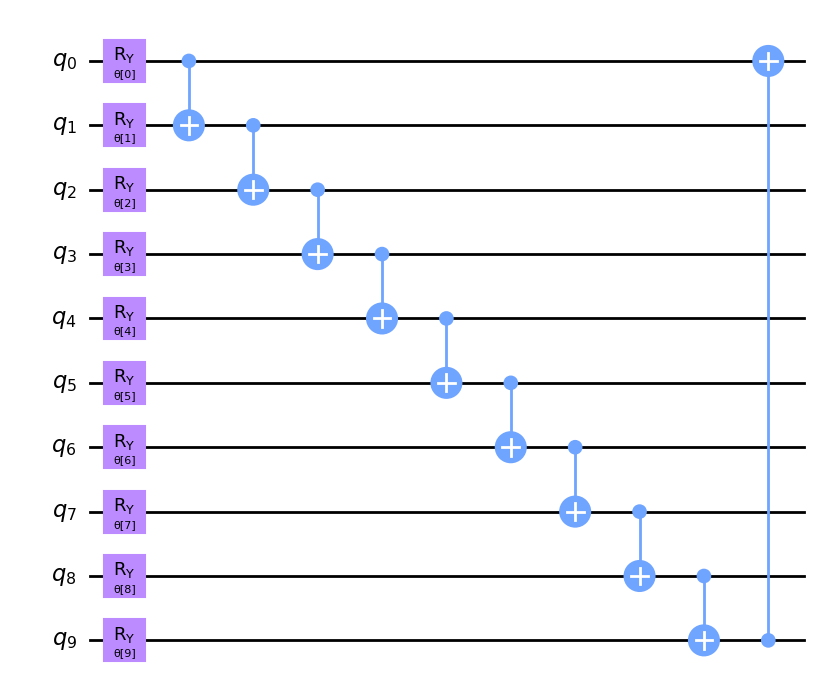

In [54]:
#Function to create the gates with parameters that we will modify through ML techniques
num_params = num_features
print(num_params);
def parametrized_gates(params):
    target = QuantumCircuit(num_features)
        
    for i in range(num_features):
        target.ry(params[i], i)
        
    for i in range(num_features-1):
        target.cx(i, i+1)
        
    target.cx(9,0)
    
    return target

#Draws the ciruit for parametrized gate
params = ParameterVector("θ", length=num_params)
circuit = parametrized_gates(params)
circuit.draw("mpl", style="clifford")

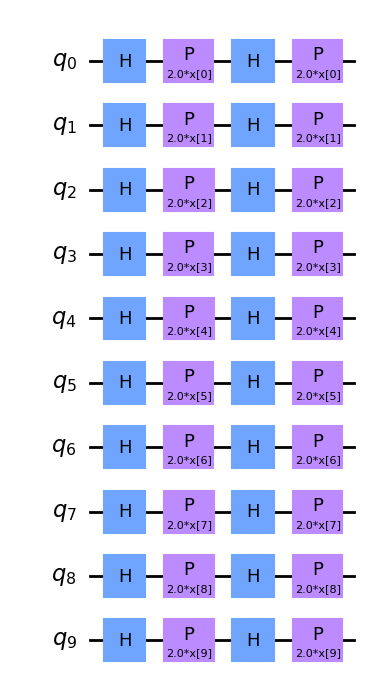

In [55]:
#Qiskits default circuit for encoding data
from qiskit.circuit.library import ZFeatureMap
feature_map = ZFeatureMap(np.size(predictors, axis=1))
feature_map.decompose().draw("mpl", style="clifford")

This makes the circuit that reduced dimensionality to 1 qubit

In [56]:
def ansatz(num_qubits):
    return RealAmplitudes(num_qubits, reps=5)


In [57]:
num_qubits = 5
circ = ansatz(num_qubits)
#circ.decompose().draw(output="mpl", style="clifford")

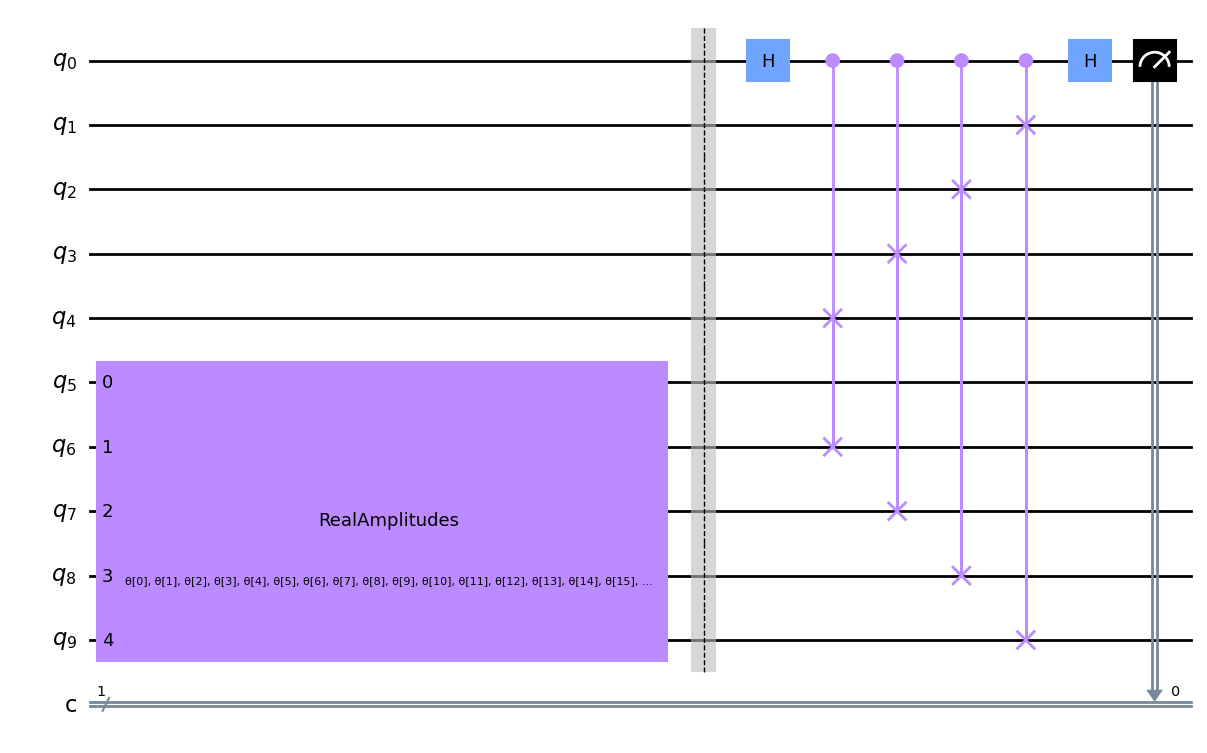

In [77]:
def createDictionary(total_sub_qubits, num_qubits):
    return_dict = set();
    j = total_sub_qubits - num_qubits
    while j < total_sub_qubits:
        return_dict.add(j + 1);
        j = j + 1;

    return return_dict;

def auto_encoder_circuit(num_latent, num_trash):
    qr = QuantumRegister(num_latent + 2 * num_trash + 1, "q")
    total_sub_qubits = num_latent + 2 * num_trash
    cr = ClassicalRegister(1, "c")
    circuit = QuantumCircuit(qr, cr)
    circuit.compose(ansatz(num_latent + num_trash), createDictionary(total_sub_qubits, num_qubits), inplace=True)
    
    circuit.barrier()
    auxiliary_qubit = 0
    #auxiliary_qubit = (num_latent + 2 * num_trash)
    # swap test
    circuit.h(auxiliary_qubit)
    for i in range(num_trash):
        circuit.cswap(auxiliary_qubit, total_sub_qubits - num_trash + i + 1, total_sub_qubits - (num_latent + num_trash + i))

    circuit.h(auxiliary_qubit)
    circuit.measure(auxiliary_qubit, cr[0])
    return circuit


num_latent = 1 # 3 qubits with the data at end
num_trash = 4
circuit = auto_encoder_circuit(num_latent, num_trash)
circuit.draw(output="mpl", style="clifford")

None


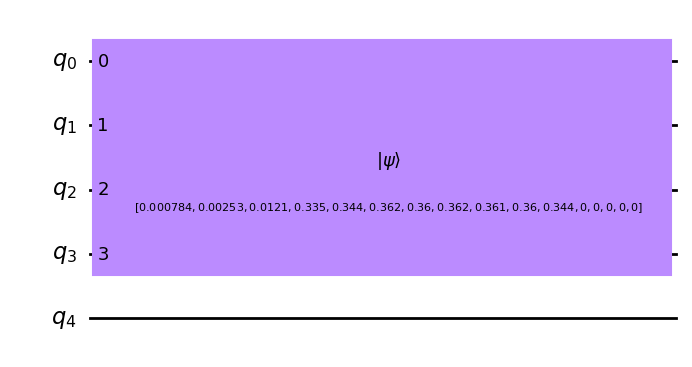

In [78]:
def amplitude_encoding(circuit, values):
    circuit.initialize(values)
    return circuit

def normalize_vector(values):
    bottom = 0;
    for val in values:
        bottom = bottom + val**2;
    bottom = bottom**0.5;
    for i in range(len(values)):
        values[i] = values[i] / bottom;
    return values;

def pad_vector(values):
    while not math.log(len(values), 2).is_integer():
        values.append(0);

input_data = [	184.37, 594.679, 2847.019630592, 78662, 80946, 85049, 84523, 85062, 84763, 84516, 80946	]
input_data_norm = normalize_vector(input_data)
print(pad_vector(input_data))
amplitude_encoding_circuit = amplitude_encoding(QuantumCircuit(4), input_data_norm)
tmp_circuit = QuantumCircuit(1)
final_circuit = QuantumCircuit(5);
final_circuit.compose(amplitude_encoding_circuit, [0,1,2,3], inplace=True)
final_circuit.compose(tmp_circuit, [4], inplace=True)
final_circuit.draw("mpl", style="clifford")

This marks the end of the encoding and dimensionality reduction algo

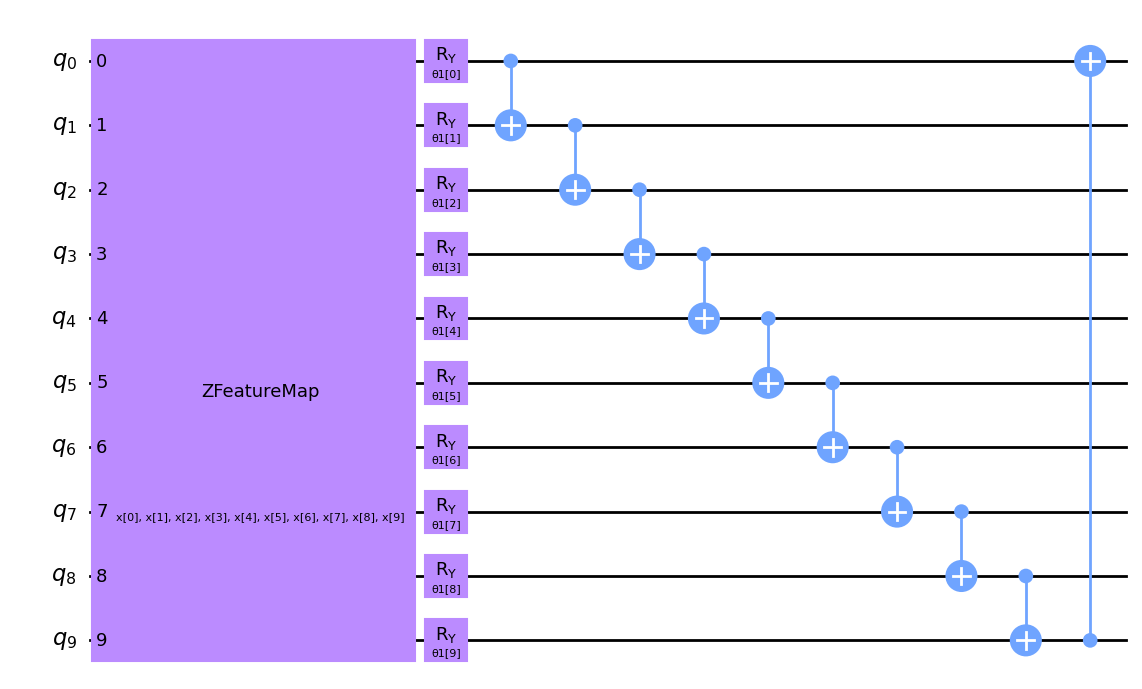

In [32]:
#Sets up full circuit with inputs and network
network = parametrized_gates(ParameterVector("θ1", length=num_params))
#network.compose(parametrized_gates(ParameterVector("θ2", length=num_params)), inplace=True)
#network.compose(parametrized_gates(ParameterVector("θ3", length=num_params)), inplace=True)
#network.compose(parametrized_gates(ParameterVector("θ4", length=num_params)), inplace=True)
ml_circuit = QuantumCircuit(num_features)
ml_circuit.compose(feature_map, inplace=True)
ml_circuit.compose(network, inplace=True)
ml_circuit.draw("mpl", style="clifford")

In [33]:
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from IPython.display import clear_output

In [34]:
#Sets up qiskit's neural network from the library
observable = SparsePauliOp.from_list([("Z" + "I" * 9, 1)])
qnn = EstimatorQNN(
    circuit=ml_circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=network.parameters,
)

In [35]:
#Function used in classifier to plot objective function at each iteration
max_iters = 600
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    #print(len(objective_func_vals)/max_iters*100, end="\r")
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [36]:
#Sets up Classifier with COBYLA optimizer
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=max_iters),
    callback=callback_graph
)

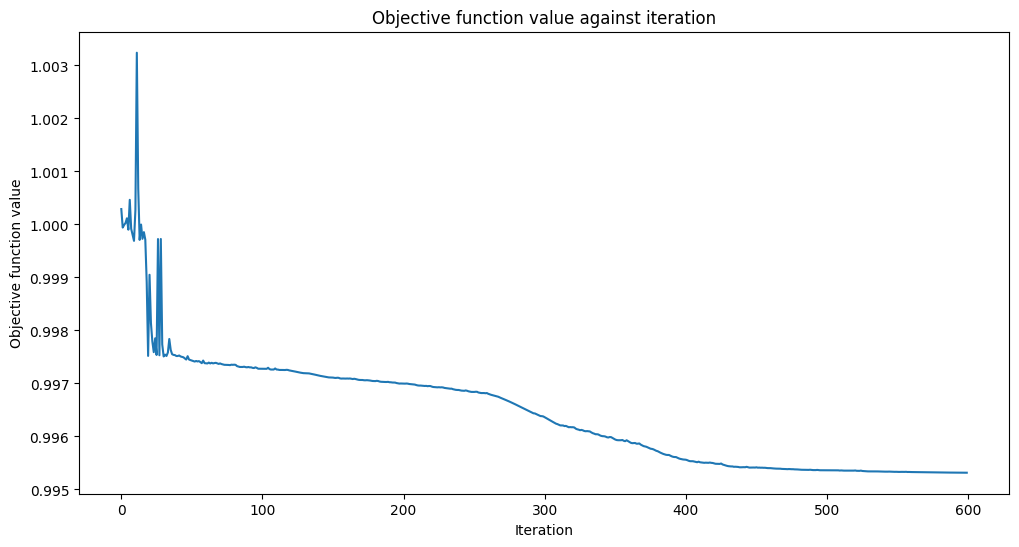

Accuracy from the test data : 52.66%


In [37]:
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

#Trains the network and plots objective function vs iteration
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(predictors, labels)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(predictors, labels), 2)}%")

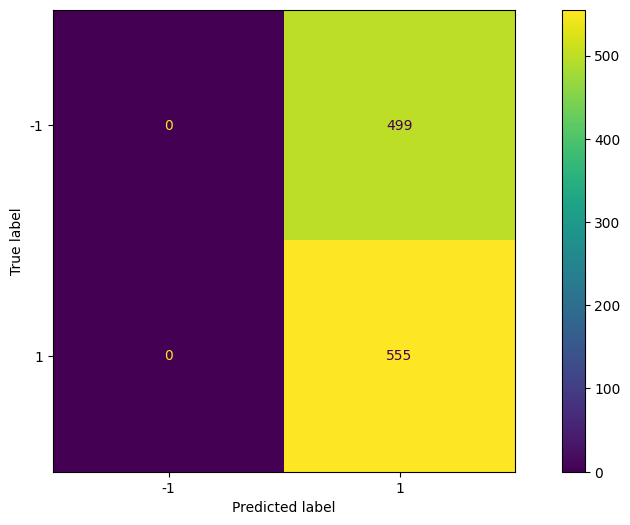

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(labels, classifier.predict(predictors))
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1,1])
display.plot()
plt.show()